v1 - pure simulation, unoptimised path

In [1]:
!pip install opencv-python-headless matplotlib

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#Import Libraries
import cv2
import numpy as np
import random
import math
from heapq import heappush, heappop
import matplotlib.pyplot as plt


In [3]:
# Set Parameters and Define Colors

WIDTH, HEIGHT = 500, 400
OBSTACLE_SIZE = 40
CIRCLE_RADIUS = 20

# Colors (BGR for OpenCV)
WHITE = (255, 255, 255)
BLUE = (255, 0, 0)     # Start
GREEN = (0, 255, 0)    # End
ORANGE = (0, 140, 255) # Obstacles
BLACK = (0, 0, 0)      # Border & outline



In [4]:
def inflate_obstacles(grid, inflation_radius):
    height, width = grid.shape
    inflated = grid.copy()
    for y in range(height):
        for x in range(width):
            if grid[y, x] == 1:  # Obstacle
                for dy in range(-inflation_radius, inflation_radius + 1):
                    for dx in range(-inflation_radius, inflation_radius + 1):
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < height and 0 <= nx < width:
                            inflated[ny, nx] = 1
    return inflated

In [5]:
# Function: Create Field with Obstacles, Start, End

def create_random_field(num_obstacles=5, block_size=40, min_margin=50):
    img = np.ones((HEIGHT, WIDTH, 3), dtype=np.uint8) * 255

    # Fixed start and end positions
    start = (WIDTH - min_margin, HEIGHT - min_margin)  # Bottom-right
    end = (min_margin, min_margin)                     # Top-left

    # Draw start and end circles
    cv2.circle(img, start, CIRCLE_RADIUS, BLUE, -1)
    cv2.circle(img, start, CIRCLE_RADIUS, BLACK, 2)
    cv2.circle(img, end, CIRCLE_RADIUS, GREEN, -1)
    cv2.circle(img, end, CIRCLE_RADIUS, BLACK, 2)

    obstacles = []

    # Randomly place non-overlapping obstacles
    for _ in range(num_obstacles):
        while True:
            x = random.randint(min_margin, WIDTH - min_margin)
            y = random.randint(min_margin, HEIGHT - min_margin)
            box = ((x - block_size // 2, y - block_size // 2),
                   (x + block_size // 2, y + block_size // 2))

            # Check for overlap with start/end
            def overlaps(pt, box):
                px, py = pt
                (x1, y1), (x2, y2) = box
                return x1 - CIRCLE_RADIUS < px < x2 + CIRCLE_RADIUS and y1 - CIRCLE_RADIUS < py < y2 + CIRCLE_RADIUS

            if overlaps(start, box) or overlaps(end, box):
                continue
            if any(overlaps(((x1+x2)//2, (y1+y2)//2), box) for (x1, y1), (x2, y2) in obstacles):
                continue

            # Place the block
            obstacles.append(box)
            cv2.rectangle(img, box[0], box[1], ORANGE, -1)
            cv2.rectangle(img, box[0], box[1], BLACK, 2)
            break

    return img, start, end



In [6]:
# Function: A Pathfinding Algorithm*

def astar(grid, start, end):
    # 8 directions: up, down, left, right, and diagonals
    neighbors = [
        (0, 1), (1, 0), (-1, 0), (0, -1),     # cardinal
        (-1, -1), (-1, 1), (1, -1), (1, 1)     # diagonal
    ]

    def heuristic(a, b):
        # Use Euclidean distance for diagonal movement
        return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5

    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, end)}
    open_heap = []
    heappush(open_heap, (fscore[start], start))

    while open_heap:
        _, current = heappop(open_heap)

        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        close_set.add(current)
        for dx, dy in neighbors:
            neighbor = (current[0] + dx, current[1] + dy)
            if not (0 <= neighbor[0] < grid.shape[1] and 0 <= neighbor[1] < grid.shape[0]):
                continue
            if grid[neighbor[1], neighbor[0]] == 1:
                continue

            move_cost = 1.4 if dx != 0 and dy != 0 else 1  # Diagonal cost ~1.4
            tentative_g_score = gscore[current] + move_cost

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, float('inf')):
                continue

            if tentative_g_score < gscore.get(neighbor, float("inf")):
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, end)
                heappush(open_heap, (fscore[neighbor], neighbor))

    return []


In [7]:
#Simulate the robot movement

class SimulatedRobot:
    def __init__(self, start_pos, direction=(0, -1)):
        self.pos = start_pos
        self.direction = direction
        self.path_index = 0

    def move_toward(self, target):
        # Move one step toward the target cell
        if self.pos == target:
            return "REACHED"

        x, y = self.pos
        tx, ty = target

        if x < tx:
            x += 1
        elif x > tx:
            x -= 1
        elif y < ty:
            y += 1
        elif y > ty:
            y -= 1

        self.pos = (x, y)

        if self.pos == target:
            return "REACHED"
        return "MOVING"

In [8]:
# Draw Path on image
def draw_path(img, path):
    for i in range(1, len(path)):
        x1, y1 = path[i - 1]
        x2, y2 = path[i]
        pt1 = (x1 * CELL_SIZE + CELL_SIZE // 2, y1 * CELL_SIZE + CELL_SIZE // 2)
        pt2 = (x2 * CELL_SIZE + CELL_SIZE // 2, y2 * CELL_SIZE + CELL_SIZE // 2)
        cv2.line(img, pt1, pt2, PATH_COLOR, 2)
    return img


In [9]:
#Run and display image

def generate_obstacle_mask(image, threshold=60, dilate_iter=2):
    # Convert image to HSV for better color separation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Detect orange obstacles (tune as needed)
    lower_orange = np.array([5, 100, 100])
    upper_orange = np.array([25, 255, 255])
    mask = cv2.inRange(hsv, lower_orange, upper_orange)

    # Dilate the mask to make obstacles "larger" (add safety buffer)
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(mask, kernel, iterations=dilate_iter)

    return dilated

def resize_for_pathfinding(mask, factor=10):
    # Resize to smaller grid for fast processing
    small = cv2.resize(mask, (mask.shape[1] // factor, mask.shape[0] // factor), interpolation=cv2.INTER_NEAREST)
    return (small > 0).astype(np.uint8)  # 1 = obstacle

def pixel_to_grid(pt, factor=10):
    return pt[0] // factor, pt[1] // factor

def grid_to_pixel(pt, factor=10):
    return pt[0] * factor + factor // 2, pt[1] * factor + factor // 2



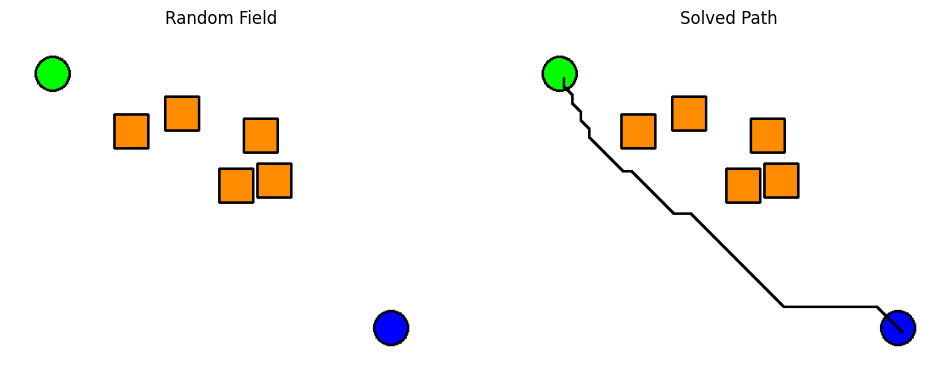

In [10]:
# Generate random field image
field_img, start_pixel, end_pixel = create_random_field()

# Create binary obstacle map
obstacle_mask = generate_obstacle_mask(field_img)
obstacle_grid = resize_for_pathfinding(obstacle_mask, factor=10)

# Convert to grid
start_grid = pixel_to_grid(start_pixel)
end_grid = pixel_to_grid(end_pixel)

# Run A* pathfinding
inflated_grid = inflate_obstacles(obstacle_grid, inflation_radius=1)  # Try 2 if needed
path = astar(inflated_grid, start_grid, end_grid)

# Draw path on copy
solved_img = field_img.copy()
if path:
    for i in range(1, len(path)):
        pt1 = grid_to_pixel(path[i - 1])
        pt2 = grid_to_pixel(path[i])
        cv2.line(solved_img, pt1, pt2, (0, 0, 0), 2)

# Display images
field_rgb = cv2.cvtColor(field_img, cv2.COLOR_BGR2RGB)
solved_rgb = cv2.cvtColor(solved_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Random Field")
plt.imshow(field_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Solved Path")
plt.imshow(solved_rgb)
plt.axis('off')

plt.show()


Grid size: 50 cols × 40 rows
Step 0: Holding position at (45, 35)
Step 1: Move LEFT
 → Position: (44, 35)
Step 2: Move UP
 → Position: (44, 34)
Step 3: Move LEFT
 → Position: (43, 34)
Step 4: Move UP
 → Position: (43, 33)
Step 5: Move LEFT
 → Position: (42, 33)
Step 6: Move UP
 → Position: (42, 32)
Step 7: Move LEFT
 → Position: (41, 32)
Step 8: Move LEFT
 → Position: (40, 32)
Step 9: Move LEFT
 → Position: (39, 32)
Step 10: Move LEFT
 → Position: (38, 32)
Step 11: Move LEFT
 → Position: (37, 32)
Step 12: Move LEFT
 → Position: (36, 32)
Step 13: Move LEFT
 → Position: (35, 32)
Step 14: Move LEFT
 → Position: (34, 32)
Step 15: Move LEFT
 → Position: (33, 32)
Step 16: Move LEFT
 → Position: (32, 32)
Step 17: Move LEFT
 → Position: (31, 32)
Step 18: Move LEFT
 → Position: (30, 32)
Step 19: Move UP
 → Position: (30, 31)
Step 20: Move LEFT
 → Position: (29, 31)
Step 21: Move UP
 → Position: (29, 30)
Step 22: Move LEFT
 → Position: (28, 30)
Step 23: Move UP
 → Position: (28, 29)
Step 24: Mov

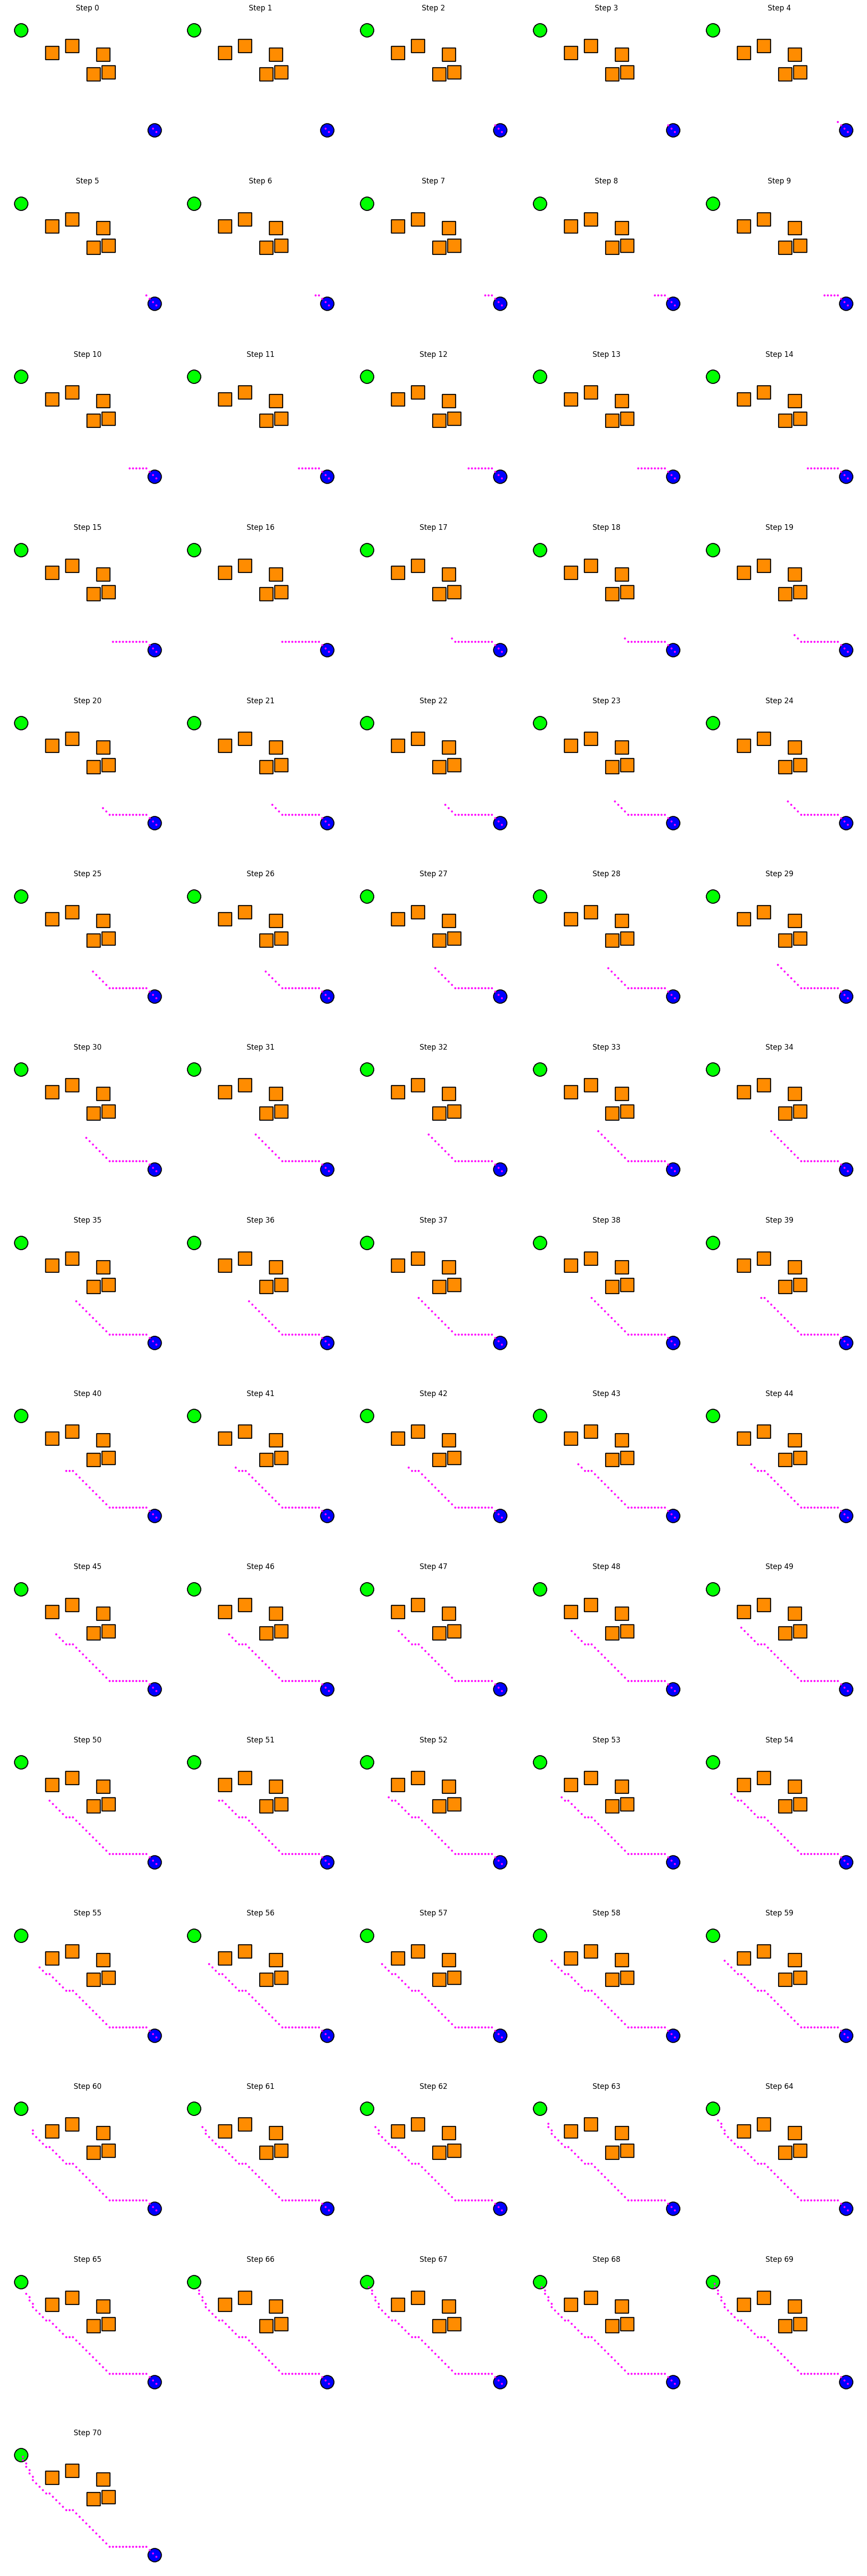

In [11]:
# === DRONE-CONTROLLED ROBOT SIMULATION ===
print(f"Grid size: {obstacle_grid.shape[1]} cols × {obstacle_grid.shape[0]} rows")

frames = []  # Store visual snapshots

robot = SimulatedRobot(start_grid, direction=(0, -1))  # Start at beginning

step = 0
while robot.path_index < len(path):
    prev_pos = robot.pos
    target = path[robot.path_index]
    command = robot.move_toward(target)

    dx = robot.pos[0] - prev_pos[0]
    dy = robot.pos[1] - prev_pos[1]

    if dx == 0 and dy == 0:
        print(f"Step {step}: Holding position at {robot.pos}")
    elif dx == 1 and dy == 0:
        print(f"Step {step}: Move RIGHT\n → Position: {robot.pos}")
    elif dx == -1 and dy == 0:
        print(f"Step {step}: Move LEFT\n → Position: {robot.pos}")
    elif dx == 0 and dy == 1:
        print(f"Step {step}: Move DOWN\n → Position: {robot.pos}")
    elif dx == 0 and dy == -1:
        print(f"Step {step}: Move UP\n → Position: {robot.pos}")
    elif dx == 1 and dy == 1:
        print(f"Step {step}: Move DOWN-RIGHT\n → Position: {robot.pos}")
    elif dx == -1 and dy == 1:
        print(f"Step {step}: Move DOWN-LEFT\n → Position: {robot.pos}")
    elif dx == 1 and dy == -1:
        print(f"Step {step}: Move UP-RIGHT\n → Position: {robot.pos}")
    elif dx == -1 and dy == -1:
        print(f"Step {step}: Move UP-LEFT\n → Position: {robot.pos}")
    else:
        print(f"Step {step}: Unrecognized move from {prev_pos} to {robot.pos}")


    if robot.pos == target:
        robot.path_index += 1

    # Frame rendering
    frame = field_img.copy()
    cv2.circle(frame, start_pixel, CIRCLE_RADIUS, BLUE, -1)
    cv2.circle(frame, start_pixel, CIRCLE_RADIUS, BLACK, 2)
    cv2.circle(frame, end_pixel, CIRCLE_RADIUS, GREEN, -1)
    cv2.circle(frame, end_pixel, CIRCLE_RADIUS, BLACK, 2)

    current_path_segment = path[:robot.path_index + 1]
    for pt in current_path_segment:
        px = grid_to_pixel(pt)
        cv2.circle(frame, px, 3, (255, 0, 255), -1)  # small magenta dot


    robot_px = grid_to_pixel(robot.pos)

    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    step += 1

print(f"Final Step: {step} — Destination reached at {robot.pos}!")

# Plot movement snapshots
n = len(frames)
cols = min(n, 5)
rows = (n + cols - 1) // cols

plt.figure(figsize=(4 * cols, 4 * rows))
for i, f in enumerate(frames):
    plt.subplot(rows, cols, i + 1)
    plt.title(f"Step {i}")
    plt.imshow(f)
    plt.axis('off')
plt.tight_layout()
plt.show()
